In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from keras import backend as K
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, Conv2D, MaxPooling2D
from tensorflow import keras
import time

In [2]:
from keras import regularizers
from keras.callbacks import EarlyStopping

from IPython.display import display



2022-08-29 16:57:31.908546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 16:57:31.908596: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Cargar flat toy dataset

In [4]:
X_train = pickle.load(open('checkpoints/flat_toy_X_train.pkl','rb'))

In [5]:
X_test = pickle.load(open('checkpoints/flat_toy_X_test.pkl','rb'))

In [37]:
y_train = pickle.load(open('checkpoints/flat_toy_y_train.pkl','rb'))

In [38]:
y_test = pickle.load(open('checkpoints/flat_toy_y_test.pkl','rb'))

In [73]:
categories = pickle.load(open('checkpoints/flat_toy_categories.pkl','rb'))

In [12]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (400, 100, 100, 3)
y_train: (400, 5)
X_test: (100, 100, 100, 3)
y_test: (100, 5)


#### Visualizamos la imagen pixelada 28 x 28

In [14]:
# Seleccionamos la primera imagen del conjunto (primer dígito)
single = X_train[0]
print("Formato de la imagen: {}".format(single.shape))

Formato de la imagen: (100, 100, 3)


#### Definición de parámetros

In [51]:
batch_size = 128
num_classes = 5
epochs = 2

# Dimensiones de la imagen de entrada
img_rows, img_cols, img_ch = 100, 100, 3

In [23]:
# Si el formato de las imágenes sólo tiene un canal (escala de grises)
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_ch, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_ch, img_rows, img_cols)
    input_shape = (img_ch, img_rows, img_cols)
# en otro caso
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_ch)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_ch)
    input_shape = (img_rows, img_cols, img_ch)

##### Comprobamos el nuevo formato de "x_train" y "x_test"

In [26]:
print("Conjunto de Training: {}".format(X_train.shape[0]), 'imágenes')
print(X_train.shape)

print()
print("Conjunto de TEST: {}".format(X_test.shape[0]), 'imágenes')
print(X_test.shape)

Conjunto de Training: 400 imágenes
(400, 100, 100, 3)

Conjunto de TEST: 100 imágenes
(100, 100, 100, 3)


In [28]:
# Píxeles de la fila 10 de la primera imagen
print(X_train[0][10])

[[ 41  20  11]
 [ 41  21  12]
 [ 37  19  10]
 [ 32  16   8]
 [ 28  13   7]
 [ 29  15   8]
 [ 34  18  11]
 [ 39  22  15]
 [ 39  22  16]
 [ 35  18  12]
 [ 34  16  11]
 [ 35  17  12]
 [ 33  17  11]
 [ 30  16   9]
 [ 29  15   9]
 [ 27  15   9]
 [ 28  16  11]
 [ 34  23  19]
 [ 52  42  39]
 [ 78  69  69]
 [113 104 107]
 [150 141 144]
 [177 170 171]
 [194 188 188]
 [200 195 195]
 [197 194 193]
 [187 183 183]
 [173 167 170]
 [157 151 152]
 [143 138 136]
 [134 129 122]
 [128 124 115]
 [127 123 112]
 [128 124 113]
 [133 129 121]
 [140 136 129]
 [140 135 132]
 [140 136 135]
 [144 140 142]
 [148 144 148]
 [151 148 152]
 [153 151 153]
 [155 152 153]
 [155 151 151]
 [154 148 149]
 [152 145 147]
 [148 141 145]
 [145 137 141]
 [140 135 135]
 [137 132 136]
 [136 131 137]
 [134 131 133]
 [134 130 128]
 [137 132 131]
 [141 135 138]
 [144 138 140]
 [147 141 143]
 [152 146 147]
 [155 149 151]
 [160 154 156]
 [164 158 159]
 [167 161 163]
 [171 165 165]
 [173 167 167]
 [177 170 170]
 [181 173 172]
 [185 177 

#### Damos formato a los píxeles de las imágenes de coma flotante de simple precisión

In [29]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#### Normalizamos los píxeles entre [0,1] para que no tengan unos más valor que otros por tener simplemente un número más alto

In [30]:
X_train /= 255
X_test /= 255

#### Visualizamos nuevamente los píxeles de la fila 10 de la primera imagen

In [32]:
print(X_train[0][10])

[[0.16078432 0.07843138 0.04313726]
 [0.16078432 0.08235294 0.04705882]
 [0.14509805 0.07450981 0.03921569]
 [0.1254902  0.0627451  0.03137255]
 [0.10980392 0.05098039 0.02745098]
 [0.11372549 0.05882353 0.03137255]
 [0.13333334 0.07058824 0.04313726]
 [0.15294118 0.08627451 0.05882353]
 [0.15294118 0.08627451 0.0627451 ]
 [0.13725491 0.07058824 0.04705882]
 [0.13333334 0.0627451  0.04313726]
 [0.13725491 0.06666667 0.04705882]
 [0.12941177 0.06666667 0.04313726]
 [0.11764706 0.0627451  0.03529412]
 [0.11372549 0.05882353 0.03529412]
 [0.10588235 0.05882353 0.03529412]
 [0.10980392 0.0627451  0.04313726]
 [0.13333334 0.09019608 0.07450981]
 [0.20392157 0.16470589 0.15294118]
 [0.30588236 0.27058825 0.27058825]
 [0.44313726 0.40784314 0.41960785]
 [0.5882353  0.5529412  0.5647059 ]
 [0.69411767 0.6666667  0.67058825]
 [0.7607843  0.7372549  0.7372549 ]
 [0.78431374 0.7647059  0.7647059 ]
 [0.77254903 0.7607843  0.75686276]
 [0.73333335 0.7176471  0.7176471 ]
 [0.6784314  0.654902   0.66

## Convierte los vectores de clase en matrices de clases binarias

In [39]:
# Etiqueta de la primera imagen
print(y_train[0])

[1. 0. 0. 0. 0.]


#### Arquitectura de la CNN

In [52]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 48, 48, 64)        0         
                                                                 
 flatten_2 (Flatten)         (None, 147456)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               18874496  
                                                      

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#### Entrenamos el modelo

In [55]:
start_time = time.time()
model.fit(X_train, y_train, 
          batch_size=batch_size, 
          epochs=epochs, 
          verbose=2)
end_time = time.time()

Epoch 1/2
4/4 - 7s - loss: 9.0961 - accuracy: 0.1575 - 7s/epoch - 2s/step
Epoch 2/2
4/4 - 5s - loss: 2.7612 - accuracy: 0.1875 - 5s/epoch - 1s/step


In [56]:
# Tiempo de entrenamiento
elapsed_time = end_time - start_time
print('Tiempo estimado de entrenamiento (min):', np.around(elapsed_time/60))

Tiempo estimado de entrenamiento (min): 0.0


#### Entrenamiento y evaluación del modelo y tiempo de ejecución

> ##### Entrenamiento: validando con el conjunto de test
> ##### Evaluación del modelo para el conjunto de test
> ##### Tiempo de ejecución

In [57]:
import time

start_time = time.time()

model.fit(X_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          verbose=2,      # visualización del progreso de entrenamiento
          validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=2)
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

elapsed_time = time.time() - start_time

Epoch 1/2
4/4 - 5s - loss: 1.6219 - accuracy: 0.2225 - val_loss: 1.6047 - val_accuracy: 0.1900 - 5s/epoch - 1s/step
Epoch 2/2
4/4 - 5s - loss: 1.5655 - accuracy: 0.2800 - val_loss: 1.5188 - val_accuracy: 0.3600 - 5s/epoch - 1s/step
4/4 - 0s - loss: 1.5188 - accuracy: 0.3600 - 220ms/epoch - 55ms/step
Test loss: 1.5188101530075073
Test accuracy: 0.36000001430511475


In [58]:
# Tiempo de entrenmiento
elapsed_time = end_time - start_time
print('Tiempo estimado de entrenamiento (min):', np.around(elapsed_time/60))

Tiempo estimado de entrenamiento (min): -5.0


#### Predecimos el conjunto de TEST con el modelo que hemos diseñado 

##### np.newaxis simplemente aumenta una dimensión a la matriz de la imagen

In [75]:
pred = model.predict(X_test[np.newaxis,1])

1/1 [==============================] - 0s 26ms/step


In [76]:
pred

array([[0.5740455 , 0.06322566, 0.07373673, 0.17330623, 0.11568586]],
      dtype=float32)

In [77]:
prediccion = pred.argmax(axis=1)

La predicción es: food


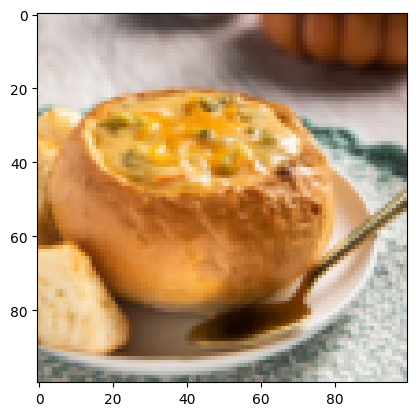

In [82]:
print('La predicción es: {}'.format(categories[prediccion[0]]))  # tiene la posición de la clase que ha tenido mayor probabilidad
img = (X_test[1]*255).reshape((100,100,3)).astype('uint8')
plt.imshow(img)
plt.show()